# Error propagation - Cpx-only
- This notebook gives a worked example showing how to propagate uncertainty for Cpx-only thermometry for different amounts of EPMA-based error on the Na$_2$O component. 
- We use the functionality provided by Pyrolite to contour the results from MonteCarlo simulations, as well as hexplot.
- If you use the pyroplot.density command, please remember to cite Pyrolite! (Williams et al., (2020). pyrolite: Python for geochemistry. Journal of Open Source Software, 5(50), 2314, doi: 10.21105/joss.02314)
- This builds on from the notebook showing how to consider error in a single phase (Liquid_Thermometry_error_prop.ipynb). We suggest you look at that first, as its simpler when you don't have to worry about two separate phases
- We consider an example Cpx composition from Gleeson et al. (2020) - https://doi.org/10.1093/petrology/egaa094

- You need to install Thermobar once on your machine, if you haven't done this yet, uncomment the line below (remove the #)

In [1]:
#!pip install Thermobar

- You will also need to install pyrolite for this example, if you haven't done so already, uncomment the line below

In [2]:
#!pip install pyrolite

In [3]:
# Import other python stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt
import sympy as sym
pd.options.display.max_columns = None
import pyrolite

## Importing data
- Note, we haven't bothered to add the "_Cpx" names after each oxide, so we simply use "suffix="_Cpx" when we load the data

In [4]:
out=pt.import_excel('Gleeson2020_Cpx_Comps.xlsx', sheet_name="Sheet1", suffix="_Cpx")
my_input=out['my_input']
myCpxs1=out['Cpxs']

## Lets select 1 Cpx to run the calculations on
- The [[ ]] keeps it as a dataframe

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,51.3863,0.467,4.1961,3.8654,0.12,16.3137,21.3039,0.378,0.0007,1.0191,0


## Work out errors
- The Cameca software used to analyse these Cpxs returns the error as absolute elemental wt%, ignoring Oxygen, for each element (helpful!). These are loaded in as Na_Err, Si_Err....
- This means that you need to do some steps to work out the analytical error on each Cpx. We show these steps below.

In [6]:
# First, we decide it easiest to use the convert_oxide_percent_to_element_weight_percent
# to convert oxide Cpx compositions into wt% to compare to these errors. Without oxygen = True, does the calculations
# without oxygen. You can use this function for any phase, just specify what suffix your phase has.

Cpx_conv=pt.convert_oxide_percent_to_element_weight_percent(df=myCpxs1, suffix='_Cpx', without_oxygen=True)

In [8]:
# Now we calculate the % error for each element. For example, for Na, we take the Cameca error (column Na_Err),
# and compare it to the concentration we just calculated in wt% for Na (column Na_wt_noO2 in the Cpx_conv dataframe)
Perc_Err_Na=100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2']
Perc_Err_Na.head()

0    8.534819
1    8.553938
2    8.520041
3    8.315210
4    7.049307
dtype: float64

In [10]:
# We now need to re-arrange these into a form that we can load into the function. We make a new dataframe of these errors
df_Cpx_Err=pd.DataFrame(data={'SiO2_Cpx_Err': 100*my_input['Si_Err']/Cpx_conv['Si_wt_noO2'],
                            'TiO2_Cpx_Err':100*my_input['Ti_Err']/Cpx_conv['Ti_wt_noO2'],
                             'Al2O3_Cpx_Err':100*my_input['Al_Err']/Cpx_conv['Al_wt_noO2'],
                             'FeOt_Cpx_Err':100*my_input['Fe_Err']/Cpx_conv['Fe_wt_noO2'],
                            'MnO_Cpx_Err':100*my_input['Mn_Err']/Cpx_conv['Mn_wt_noO2'],
                            'MgO_Cpx_Err':100*my_input['Mg_Err']/Cpx_conv['Mg_wt_noO2'],
                            'CaO_Cpx_Err':100*my_input['Ca_Err']/Cpx_conv['Ca_wt_noO2'],
                            'Na2O_Cpx_Err':100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2'],
                            'Cr2O3_Cpx_Err':100*my_input['Cr_Err']/Cpx_conv['Cr_wt_noO2'],
                               'K2O_Cpx_Err': 100*my_input['K_Err']/Cpx_conv['K_wt_noO2']}, index=[0])

## Lets select 1 Cpx, and its corresponding error as an example
- using [[ ]] keeps it as a dataframe, we reset the index because sometimes this can cause python mayhem. 

In [11]:
Cpx_1=myCpxs1.iloc[[0]].reset_index(drop=True)
Cpx_1_Err=df_Cpx_Err.iloc[[0]].reset_index(drop=True)

In [103]:
Cpx_1_Err

,SiO2_Cpx_Err,TiO2_Cpx_Err,Al2O3_Cpx_Err,FeOt_Cpx_Err,MnO_Cpx_Err,MgO_Cpx_Err,CaO_Cpx_Err,Na2O_Cpx_Err,Cr2O3_Cpx_Err,K2O_Cpx_Err
0,1.186416,2.148544,0.907273,3.056648,27.309951,1.129271,0.858363,8.534819,5.172622,1934.77739


## Lets calculate the errors for this Cpx
- You could do this for all Cpxs, rather than just this 1 sample, but it'll take longer, so we do a cut down version here!

In [41]:
Calc_Cpx_dist=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err,
                                             phase_err_type="Perc", duplicates=20000, err_dist="normal")

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets calculate pressures and temperatures using all options for Cpx-only thermobarometry

In [42]:
Calc_PT=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist)

## Lets plot these calculations using the Wang et al. (2021) thermometer and barometer
- You can see that despite random input errors, P and T end up correlated in the resulting distribution
- You can also see that pressure is controlled predominantly by the error on the Na2O component, with scatter around this trend

Text(0, 0.5, 'Na$_2$O Cpx')

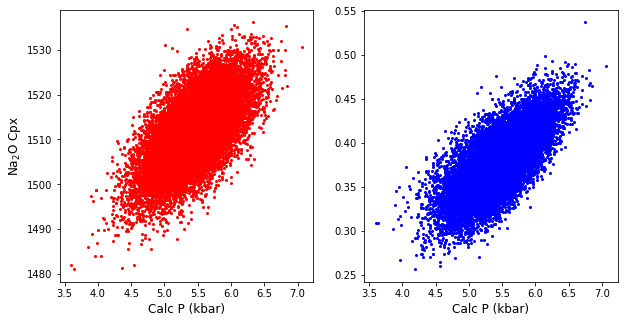

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['T_Wang21_eq2'], '.r' )
ax2.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['Na2O_Cpx'], '.b' )
ax1.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')
ax1.set_ylabel('Na$_2$O Cpx')


## A more robust way to show this
- If you play around with duplicates = , you'll see that the more points you ask for, the more spread in pressure space. 
- It is more robust to contour results
- First, we show how to do this using hexbin (matplotlib)
- We underlie the published error on the barometer, at the average calculated composition.

<ErrorbarContainer object of 3 artists>

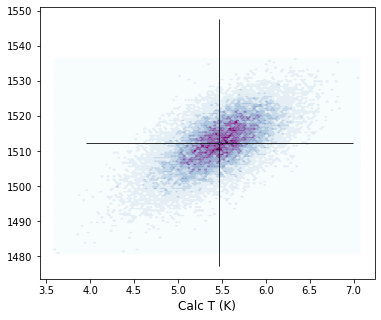

In [75]:
fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))

ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

## But this is still hard to visualize!
- We can add contours using pyrolite, so we can visualize where 67% of simulations lie, and where 95% of simulations lie
- You will have to play around a bit with the number of bins, and the extent parameter.
- We always plot PT first, then use that to work out the extent, which tells the code where to look for contours in. This only needs to be approximate. 
- This step can be slow, if you are using 4-8 Gb of Ram, you might want to reduce the number of duplicates when you make the samples. 
- Remember to cite Pyrolite if you use these contours!

Text(0, 0.5, 'Calc T (K)')

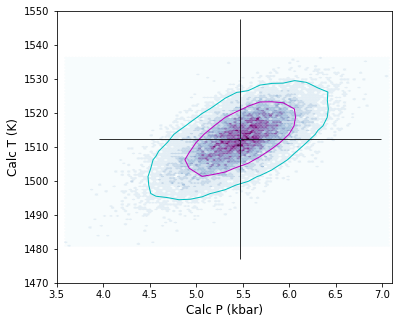

In [79]:
fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))


extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=30, label_contours=False)
ax1.set_xlim([3.5, 7.1])
ax1.set_ylim([1470,  1550])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

## Lets work out what would happen if we doubled the analytical error on Na2O

In [60]:
# First, lets duplicate the error dataframe
df_Cpx_Err_2Na=df_Cpx_Err.copy()
# Lets set Na2O error to 2* what it was
df_Cpx_Err_2Na['Na2O_Cpx_Err']=2*df_Cpx_Err['Na2O_Cpx_Err']
# And lets take sample 0 again
Cpx_1_Err_2Na=df_Cpx_Err_2Na.iloc[[0]].reset_index(drop=True)
# Lets simulate some new Cpxs. 
Calc_Cpx_dist_2Na=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err_2Na,
                                             phase_err_type="Perc", duplicates=20000, err_dist="normal")
# And lets calculate pressures
Calc_PT_2Na=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist_2Na)

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets plot these new errors vs. the old errors

C:\Users\penny\anaconda3\lib\site-packages\pyrolite\util\plot\density.py:202: UserWarning: The following kwargs were not used by contour: 'width'
  cs = contour(


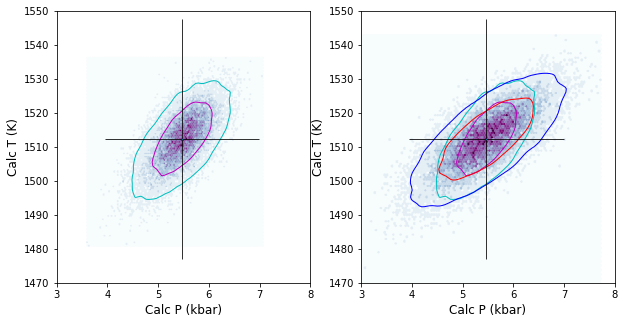

In [84]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)


extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')




extent2=(3.5, 7, 1470, 1540)
ax2.hexbin(Calc_PT_2Na['P_Wang21_eq1'],
           Calc_PT_2Na['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax2.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False, width=0.5)

Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['r', 'blue'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False)

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax2.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlim([3, 8])
ax1.set_ylim([1470,  1550])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')
ax2.yaxis.set_tick_params(which='both', labelbottom=True)

## Lets make a pretty figure for publication with just the stated errors for Wang and Putirka thermobarometers, but overlay an additional contour for bigger Na2O errors

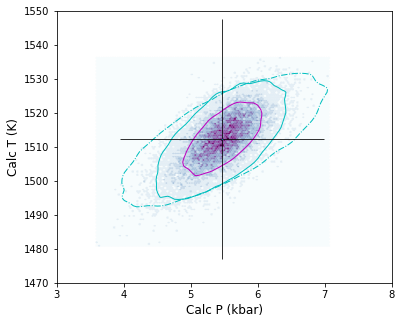

In [96]:
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)


Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([3, 8])
ax1.set_ylim([1470,  1550])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error.png', dpi=200)

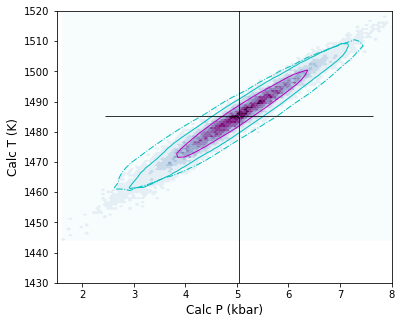

In [106]:
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(1, 10, 1430, 1540)
ax1.hexbin(Calc_PT['P_Put_Teq32d_Peq32b'],
           Calc_PT['T_Put_Teq32d_Peq32b'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

extent2=(1, 10, 1430, 1540)

Calc_PT_2Na.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Put_Teq32d_Peq32b']),
             np.mean(Calc_PT['T_Put_Teq32d_Peq32b']),
             xerr=2.6, yerr=58,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([1.5, 8])
ax1.set_ylim([1430,  1520])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error_Put.png', dpi=200)

In [109]:
Stats_P=pt.av_noise_samples_series(Calc_PT['P_Wang21_eq1'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.471287,5.481162,0.389856,7.063964,3.599682


In [110]:
Stats_T=pt.av_noise_samples_series(Calc_PT['T_Wang21_eq2'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_T

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1512.31203,1512.475301,6.988963,1536.169793,1480.958898


In [112]:
Stats_T=pt.av_noise_samples_series(Calc_PT_2Na['T_Wang21_eq2'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_T

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1512.355455,1512.486971,7.968166,1542.754602,1468.574768


In [97]:
Stats_P=pt.av_noise_samples_series(Calc_PT_2Na['P_Wang21_eq1'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.471939,5.468769,0.621062,7.716995,2.860175


In [100]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT_2Na['P_Put_Teq32d_Peq32b'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.00506,5.021265,0.959091,8.484138,0.519245


In [108]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['P_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,5.034602,5.028013,0.854451,8.640107,1.628042


In [111]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['T_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,Mean_calc,Median_calc,St_dev_calc,Max_calc,Min_calc
0,0.0,1485.213185,1485.267384,9.723965,1522.235212,1444.384438
